In [1]:
!pip install --no-deps torchvision
!pip install torchsummary
!pip install tqdm
!pip install sklearn
!pip install matplotlib

In [2]:
import torch
import torch.nn as nn

import torch.optim as optim

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from tqdm import tqdm

from itertools import chain
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

/home/kirsr/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:

# В этой части лабораторной работы вам предстоит реализовать и обучить автокодировочную сеть на наборе данных MNIST.
# Сценарий выполнения кода:
# 1. Обучение автокодировщика.
# 2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
# 3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
# и анимация результата.
# 4. Обучение простого классификатора на исходных данных (изображениях цифр) и на векторах в скрытом пространстве.
# 5. Проверка полученных классификаторов на тестовых данных.

class Encoder(nn.Module):
    # Класс кодивщика, необходимо реализовать.

    def __init__(self, inputs, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.fc1 = nn.Linear(inputs, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, latent_size)
        self.relu = nn.ReLU()
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        # x = x.flatten()
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x) 
        # ============
        return x


class Decoder(nn.Module):
    # Класс декодировщика, необходимо реализовать.

    def __init__(self, latent_size, outputs):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, outputs)
        self.relu = nn.ReLU()
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        # x = x.flatten()
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x) 
        # ============
        return x


class SimpleClassifier(nn.Module):
    # Класс простого классификатора.

    def __init__(self, inputs, outputs):
        super().__init__()
        self.fc = nn.Linear(inputs, outputs)

        self._inputs = inputs

    def forward(self, x):
        x = x.reshape(-1, self._inputs)
        x = self.fc(x)
        return x


class LatentSpaceDataset(Dataset):
    # Класс для преобразования изображений в вектора скрытого пространства.

    def __init__(self, orig_space_data_loader, encoder):
        super().__init__()
        self._data = list()
        for batch, target in orig_space_data_loader:
            latent_space_imgs = encoder(batch).detach()
            self._data.extend(zip(latent_space_imgs, target))

    def __len__(self):
        return len(self._data)

    def __getitem__(self, i):
        return self._data[i]


def train_ae(data_loader, encoder, decoder, epochs, lr):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

    encoder.train()
    decoder.train()

    print('Обучение автокодировщика..')

    loss_func = nn.MSELoss()  # функция потерь, нужно выбрать
    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)  # оптимизатор, нужно выбрать.
    loss_history = list()
    for epoch in tqdm(range(epochs)):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            batch=batch.to(device)
            optimizer.zero_grad()
            loss = loss_func(decoder(encoder(batch)).reshape(-1, 1, 28, 28), batch)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.log().item())
            # ============
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    print('Готово!')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()


def train_classifier(data_loader, model, epochs, lr):
    # Функция для обучения классификатора.

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    print('Обучение классификатора..')
    for epoch in tqdm(range(epochs)):
        for i, (batch, target) in enumerate(data_loader):
            batch=batch.to(device)
            target=target.to(device)
            optimizer.zero_grad()
            loss = loss_func(model(batch), target)
            loss.backward()
            optimizer.step()
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    print('Готово!')
    model.eval()


def test_classifier(data_loader, classifier):
    # Функция для тестирования классификатора.

    batch, target = next(iter(data_loader))
    batch = batch.to(device)
    target = target.to(device)
    print(accuracy_score(torch.argmax(classifier(batch), dim=1).detach().numpy(), target))


def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t


def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

cuda
Архитектура кодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 64]           8,256
Total params: 574,400
Trainable params: 574,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.19
Estimated Total Size (MB): 2.20
----------------------------------------------------------------

Архитектура декодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           8,320
            Linear-2                  [-1, 25

 10%|█         | 1/10 [00:04<00:44,  4.92s/it]

Эпоха 1 / 10. Потери на последнем пакете: 0.03550543636083603


 20%|██        | 2/10 [00:09<00:39,  4.93s/it]

Эпоха 2 / 10. Потери на последнем пакете: 0.0287121944129467


 30%|███       | 3/10 [00:14<00:34,  4.91s/it]

Эпоха 3 / 10. Потери на последнем пакете: 0.022702043876051903


 40%|████      | 4/10 [00:19<00:29,  4.89s/it]

Эпоха 4 / 10. Потери на последнем пакете: 0.020897436887025833


 50%|█████     | 5/10 [00:24<00:24,  4.85s/it]

Эпоха 5 / 10. Потери на последнем пакете: 0.019311679527163506


 60%|██████    | 6/10 [00:29<00:19,  4.85s/it]

Эпоха 6 / 10. Потери на последнем пакете: 0.0168620515614748


 70%|███████   | 7/10 [00:33<00:14,  4.81s/it]

Эпоха 7 / 10. Потери на последнем пакете: 0.014322815462946892


 80%|████████  | 8/10 [00:38<00:09,  4.83s/it]

Эпоха 8 / 10. Потери на последнем пакете: 0.014662995003163815


 90%|█████████ | 9/10 [00:43<00:04,  4.83s/it]

Эпоха 9 / 10. Потери на последнем пакете: 0.014255003072321415


100%|██████████| 10/10 [00:48<00:00,  4.85s/it]

Эпоха 10 / 10. Потери на последнем пакете: 0.013294572941958904
Готово!


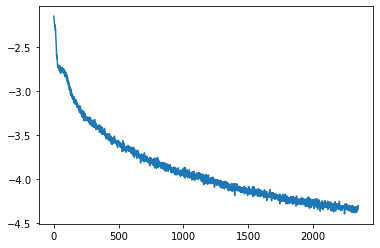

In [9]:
LATENT_SIZE = 64  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 1e-4

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

encoder = Encoder(28 * 28, LATENT_SIZE)
decoder = Decoder(LATENT_SIZE,  28 * 28)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
encoder=encoder.to(device)
decoder=decoder.to(device)

print('Архитектура кодировщика: ')
summary(encoder, [[28 * 28]])
print()
print('Архитектура декодировщика: ')
summary(decoder, [[LATENT_SIZE]])

train_data = MNIST('data', train=True, download=True, transform=ToTensor())
test_data = MNIST('data', train=False, download=True, transform=ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE)

Проецирование скрытого пространства на плоскость..


/home/kirsr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kirsr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Готово!


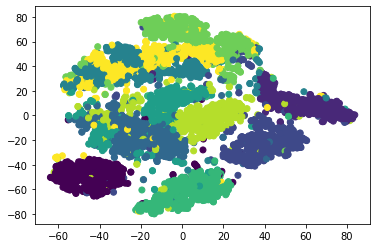

In [10]:
test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list)

print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
encoder=encoder.to("cpu")
decoder=decoder.to("cpu")
latent_imgs_emb = [encoder(img.unsqueeze(0))[0].detach().numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
print('Готово!')
plt.show()

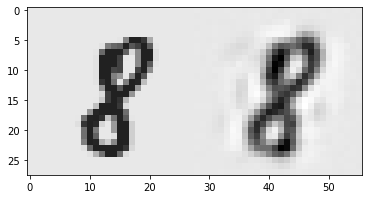

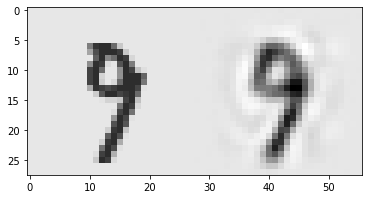

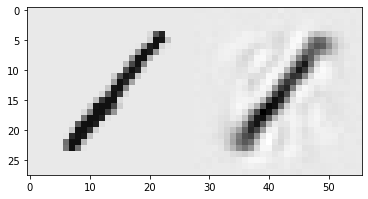

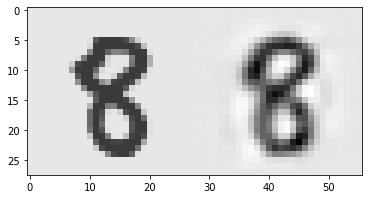

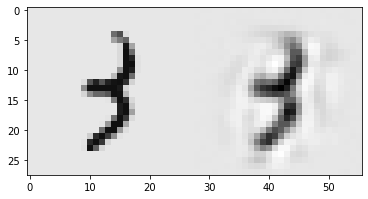

Расчет анимации..


/home/kirsr/.local/lib/python3.8/site-packages/torch/_tensor.py:581: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Готово!


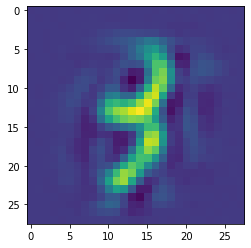

In [11]:
latent_imgs = encoder(imgs)
restored_imgs = decoder(latent_imgs)

for i in range(5):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs.view(-1, 1, 28, 28)[i][0].detach()))
    plt.imshow(orig_restored.numpy(), cmap='Greys')
    plt.show()

print('Расчет анимации..')
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(50 * 20):
    frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
    vec_index = i // frames_per_conn
    t = i % frames_per_conn / frames_per_conn
    interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t).T
    restored_img = decoder(interp_vec.resize(64, 1).T)
    # if x_classifier(restored_img).argmax() == 5:
    animation_data.append(restored_img.view(-1, 1, 28, 28)[0][0].detach().numpy())
# print(len(animation_data))
print('Готово!')

animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))
from IPython.display import HTML
HTML(animation.to_jshtml())

In [7]:
x_classifier = SimpleClassifier(28 * 28, 10)

x_classifier=x_classifier.to(device)
train_classifier(train_data_loader, x_classifier, epochs=10, lr=1e-4)

latent_space_train_data_loader = DataLoader(LatentSpaceDataset(train_data_loader, encoder), batch_size=BATCH_SIZE, shuffle=True)

z_classifier = SimpleClassifier(LATENT_SIZE, 10)
z_classifier=z_classifier.to(device)
train_classifier(latent_space_train_data_loader, z_classifier, epochs=10, lr=1e-4)

orig_test_data_loader = DataLoader(test_data, batch_size=1024, shuffle=True)
latent_test_data_loader = DataLoader(LatentSpaceDataset(orig_test_data_loader, encoder), batch_size=1024, shuffle=True)
device="cpu"
x_classifier=x_classifier.to(device)
z_classifier=z_classifier.to(device)
test_classifier(orig_test_data_loader, x_classifier)
test_classifier(latent_test_data_loader, z_classifier)

Обучение классификатора..


 10%|█         | 1/10 [00:03<00:35,  3.91s/it]

Эпоха 1 / 10. Потери на последнем пакете: 1.4676192998886108


 20%|██        | 2/10 [00:07<00:31,  3.92s/it]

Эпоха 2 / 10. Потери на последнем пакете: 1.1979880332946777


 30%|███       | 3/10 [00:11<00:27,  3.95s/it]

Эпоха 3 / 10. Потери на последнем пакете: 0.9376673698425293


 40%|████      | 4/10 [00:16<00:24,  4.11s/it]

Эпоха 4 / 10. Потери на последнем пакете: 0.6950664520263672


 50%|█████     | 5/10 [00:20<00:20,  4.20s/it]

Эпоха 5 / 10. Потери на последнем пакете: 0.6384431719779968


 60%|██████    | 6/10 [00:24<00:16,  4.13s/it]

Эпоха 6 / 10. Потери на последнем пакете: 0.6388000249862671


 70%|███████   | 7/10 [00:28<00:12,  4.13s/it]

Эпоха 7 / 10. Потери на последнем пакете: 0.6432868242263794


 80%|████████  | 8/10 [00:32<00:08,  4.12s/it]

Эпоха 8 / 10. Потери на последнем пакете: 0.3912194073200226


 90%|█████████ | 9/10 [00:36<00:04,  4.08s/it]

Эпоха 9 / 10. Потери на последнем пакете: 0.5285346508026123


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]

Эпоха 10 / 10. Потери на последнем пакете: 0.5025652647018433
Готово!


Обучение классификатора..


 10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Эпоха 1 / 10. Потери на последнем пакете: 2.052730083465576


 20%|██        | 2/10 [00:01<00:04,  1.71it/s]

Эпоха 2 / 10. Потери на последнем пакете: 1.8444901704788208


 30%|███       | 3/10 [00:01<00:03,  1.75it/s]

Эпоха 3 / 10. Потери на последнем пакете: 1.6122926473617554


 40%|████      | 4/10 [00:02<00:03,  1.72it/s]

Эпоха 4 / 10. Потери на последнем пакете: 1.325115442276001


 50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Эпоха 5 / 10. Потери на последнем пакете: 1.1696089506149292


 60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

Эпоха 6 / 10. Потери на последнем пакете: 1.123187780380249


 70%|███████   | 7/10 [00:04<00:01,  1.75it/s]

Эпоха 7 / 10. Потери на последнем пакете: 1.0196402072906494


 80%|████████  | 8/10 [00:04<00:01,  1.73it/s]

Эпоха 8 / 10. Потери на последнем пакете: 0.8415998816490173


 90%|█████████ | 9/10 [00:05<00:00,  1.68it/s]

Эпоха 9 / 10. Потери на последнем пакете: 0.9380455017089844


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Эпоха 10 / 10. Потери на последнем пакете: 0.8711630702018738
Готово!


0.8974609375
0.8310546875
